# Stochastic Differential Equations

In this notebook, we will learn how to simulate ordinary differential equations (ODEs) and their stochastic counterparts, stochastic differential equations (SDEs).

## Import Required Libraries

In [1]:
!pip install -qU matplotlib numpy seaborn torch tqdm

In [2]:
# Abstract base classes (ABCs) and abstract methods define signatures without
# implementations, acting as templates that all subclasses must follow to be
# instantiated. Abstract methods are marked by the @abstractmethod decorator.
from abc import ABC, abstractmethod

# The Optional type hint specifies that a variable may be of a given type or of
# type None. The math module provides common mathematical functions and constants.
# tdqm displays a progress bar over loops and iterables.
from typing import Optional
from tqdm import tqdm
import math

# NumPy enables efficient numerical computations, while Matplotlib's pyplot pro-
# vides a plotting interface. The Axes class encapsulates all elements of a sub-
# plot within a Matplotlib Figure. Seaborn extends Matplotlib by providing addi-
# tional tools for statistical data visualization.
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.axes._axes import Axes

# PyTorch is a framework that facilitates the training of ML models. Its distri-
# butions module provides a wide range of probability distributions. The func mo-
# dule provides higher-order functions which transform existing functions. In par-
# ticular, vectorizing maps enable efficient batching of operations over multiple
# samples, while the Jacobian matrix contains the first-order partial derivatives
# of a function, i.e., partial f_i / partial x_j.
import torch
import torch.distributions as D
from torch.func import vmap, jacrev

# Set the device to CUDA if a GPU is available; otherwise, fall back to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams["font.family"] = "DejaVu Sans Mono"

## Introduction

In both ordinary and stochastic differential equations, the central object of study is the time-dependent vector field $u$, defined as
$$
u: \mathbb{R}^d\times [0, 1]\to\mathbb{R}^d, \; (x, t)\mapsto u_t(x).
$$
This function maps a position $x$ and time $t$ to a _velocity vector_ $u_t(x)\in\mathbb{R}^d$. The ODE is then given by
$$
\mathrm dX_t = u_t(X_t)\,\mathrm dt, \; X_0 = x_0,
$$
where $x_0$ denotes the initial condition. The SDE adds a noise term corresponding to Brownian motion $\left(W_t\right)_{0\leq t\leq 1}$, and is given by
$$
\mathrm dX_t = u_t(X_t)\,\mathrm dt + \sigma_t\,\mathrm dW_t, \; X_0 = x_0.
$$
The deterministic term $u_t(x)$ is referred to as the _drift_, while the amount of noise added is governed by the _diffusion coefficient_ $\sigma_t$.

In [3]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of an ODE.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        drift_coefficient : torch.Tensor, shape (batch_size, dim)
            Drift coefficient u_t(x_t) at the given time.
        """
        pass

In [4]:
class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of an SDE.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        drift_coefficient : torch.Tensor, shape (batch_size, dim)
            Drift coefficient u_t(x_t) at the given time.
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of an SDE.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        diffusion_coefficient : torch.Tensor, shape (batch_size, dim)
            Diffusion coefficient sigma_t at the given time.
        """
        pass

ODEs and SDEs describe the motion of a particle through space. The ODE starts at an initial position $X_0 = x_0$ and follows its velocity $u_t(X_t)$ deterministically. The SDE extends this idea by adding a random noise term with scale given by $\sigma_t$. The trajectories $X_t$ generated by these equations are called _solutions_ of the ODE or SDE, while numerical methods for computing these solutions involve simulating or _integrating_ the equation over time.

Let us now implement the Euler and Euler-Maruyama methods for integrating ODEs and SDEs, respectively. We discretize the ODE as
$$
\mathrm dX_t = u_t(X_t)\,\mathrm dt\rightarrow X_{t + h} = X_t + hu_t(X_t),
$$
where $h = \Delta t$ is the step size or _time increment_. To discretize the SDE, we follow
$$
\mathrm dX_t = u(X_t)\,\mathrm dt + \sigma_t\,\mathrm dW_t
\rightarrow X_{t + h} = X_t + hu_t(X_t) + \sigma_t\big(z_t\sqrt{h}\big),
$$
where $z_t\sim\mathcal N(0, I_d)\rightarrow z_t\sqrt{h}\sim\mathcal N(0, hI_d)$ approximates the Wiener increment $W_{t + h} - W_t\sim\mathcal N\left(0, hI_d\right)$.

Note that in the code below, `@torch.no_grad()` disables gradient tracking during the forward pass, such that no computation graph is built and gradients are not computed during the backward pass. However, this suffices for inference (prediction).

In [5]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Perform a single simulation step.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).
        dt : torch.Tensor, shape ()
            Time increment (broadcasts across batch).

        Returns
        -------
        nxt : torch.Tensor, shape (batch_size, dim)
            State at time t + dt.
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulate across the specified time steps.

        Parameters
        ----------
        x_init : torch.Tensor, shape (batch_size, dim)
            Initial state at time ts[0]
        ts : torch.Tensor, shape (num_timesteps, )
            Vector of monotonically increasing time points defining the simula-
            tion grid.

        Returns
        -------
        x_final : torch.Tensor, shape (batch_size, dim)
            Final state at time ts[-1]
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulate across the specified time steps and record the full trajectory.

        Parameters
        ----------
        x_init : torch.Tensor, shape (batch_size, dim)
            Initial state at time ts[0].
        ts : torch.Tensor, shape (num_timesteps, )
            Vector of monotonically increasing time points defining the simula-
            tion grid.

        Returns
        -------
        xs : torch.Tensor, shape (batch_size, num_timesteps, dim)
            Trajectory of states at each time step, including the initial state.
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim = 1)

In [6]:
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        nxt = xt + self.ode.drift_coefficient(xt, t) * h
        return nxt

In [7]:
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        drift = h * self.sde.drift_coefficient(xt, t)
        diffusion = self.sde.diffusion_coefficient(xt, t) * torch.sqrt(h) * torch.randn_like(xt)

        nxt = xt + drift + diffusion
        return nxt

Let us now consider Brownian motion. This corresponds to setting the drift to zero, the diffusion coefficient to a constant $\sigma_t = \sigma$, and the initial condition to $X_0 = 0$. In other words, we have
$\mathrm dX_t = \sigma\,\mathrm dW_t, \, X_0 = 0$.

In [8]:
class BrownianMotion(SDE):
    def __init__(self, sigma: float):
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient for Brownian motion.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        drift : torch.Tensor, shape (batch_size, dim)
            Drift coefficient (the zero vector) for Brownian motion.
        """
        drift = torch.zeros_like(xt)
        return drift

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient for Brownian motion.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        diffusion : torch.Tensor, shape (batch_size, dim)
            Diffusion coefficient (sigma) for Brownian motion.
        """
        diffusion = torch.ones_like(xt) * self.sigma
        return diffusion

In [9]:
def plot_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, ax: Optional[Axes] = None):
    """
    Plot the trajectories of a one-dimensional SDE given a set of initial states
    (x0) and simulation time steps (time steps).

    Parameters
    ----------
    x0 : torch.Tensor, shape (num_trajectories, 1)
        Initial state at time 0 for each trajectory.
    simulator : Simulator
        Object used to generate trajectories.
    timesteps : torch.Tensor, shape (num_timesteps, )
        Time steps along which to simulate the trajectories.
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on. Uses the current axes if None.
    """
    if ax is None:
        ax = plt.gca()
    # Simulate trajectories: shape (num_trajectories, num_timesteps, 1)
    trajectories = simulator.simulate_with_trajectory(x0, timesteps)
    for trajectory_idx in range(trajectories.shape[0]):
        # Extract a single trajectory: shape (num_timesteps, )
        trajectory = trajectories[trajectory_idx, :, 0]
        # Plot the trajectory, moving tensors to the CPU if necessary for
        # matplotlib compatibility
        ax.plot(timesteps.cpu(), trajectory.cpu())

100%|██████████| 499/499 [00:00<00:00, 4232.46it/s]


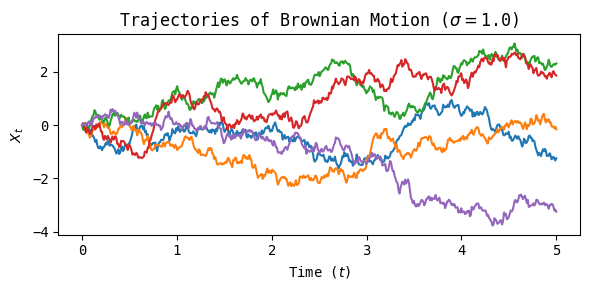

In [10]:
sigma = 1.0
# Create a Brownian motion SDE object with the given diffusion coefficient
brownian_motion = BrownianMotion(sigma)
# Create a simulator object for the SDE
simulator = EulerMaruyamaSimulator(sde = brownian_motion)
# Set the initial state (5 trajectories) and set of simulation time steps (500).
# Move both tensors to the GPU if available.
x0 = torch.zeros(5, 1).to(device)
ts = torch.linspace(0.0, 5.0, 500).to(device)

plt.figure(figsize = (6, 3))
ax = plt.gca()
ax.set_title(r"Trajectories of Brownian Motion ($\sigma = $" + str(sigma) + ")")
ax.set_xlabel(r"Time ($t$)")
ax.set_ylabel(r"$X_t$")
plot_trajectories_1d(x0, simulator, ts, ax)
plt.tight_layout()

The Ornstein-Uhlenbeck process sets the drift to $u_t(X_t) = -\theta X_t$ with constant $\sigma_t = \sigma$, such that
$$
\mathrm dX_t = -\theta X_t\,\mathrm dt + \sigma\,\mathrm dW_t, \, X_0 = x_0.
$$
$\theta > 0$ therefore acts as a _force constant_, driving mean reversion toward the origin.

We may compute the _stationary distribution_ $p_s(x)$ as
$$
\begin{align*}
J(x) & = \left[-\theta x - \frac{\sigma^2}{2}\frac{\mathrm d}{\mathrm dx}\right]p_s(x) = 0 \\
\left(-\theta x\right)p_s(x) & = \frac{\sigma^2}{2}\frac{\mathrm dp_s(x)}{\mathrm dx} \\
\int\frac{\mathrm dp_s(x)}{p_s(x)} & = -\int\frac{2\theta x}{\sigma^2}\,\mathrm dx \\
\log p_s(x) & = -\frac{\theta x^2}{\sigma^2} + C \\
p_s(x) & = C\exp\left[-\frac{\theta x^2}{\sigma^2}\right],
\end{align*}
$$
which is distributed as $\mathcal N\left(0, \frac{\sigma^2}{2\theta}\right)$.

In [11]:
class OUProcess(SDE):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift vector of a set of Ornstein-Uhlenbeck processes.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        drift : torch.Tensor, shape (batch_size, dim)
            Drift vectors.
        """
        drift = -self.theta * xt
        return drift

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion vector of a set of Ornstein-Uhlenbeck processes.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        diffusion : torch.Tensor, shape (batch_size, dim)
            Diffusion vectors.
        """
        diffusion = torch.ones_like(xt) * self.sigma
        return diffusion

100%|██████████| 999/999 [00:00<00:00, 7605.88it/s]


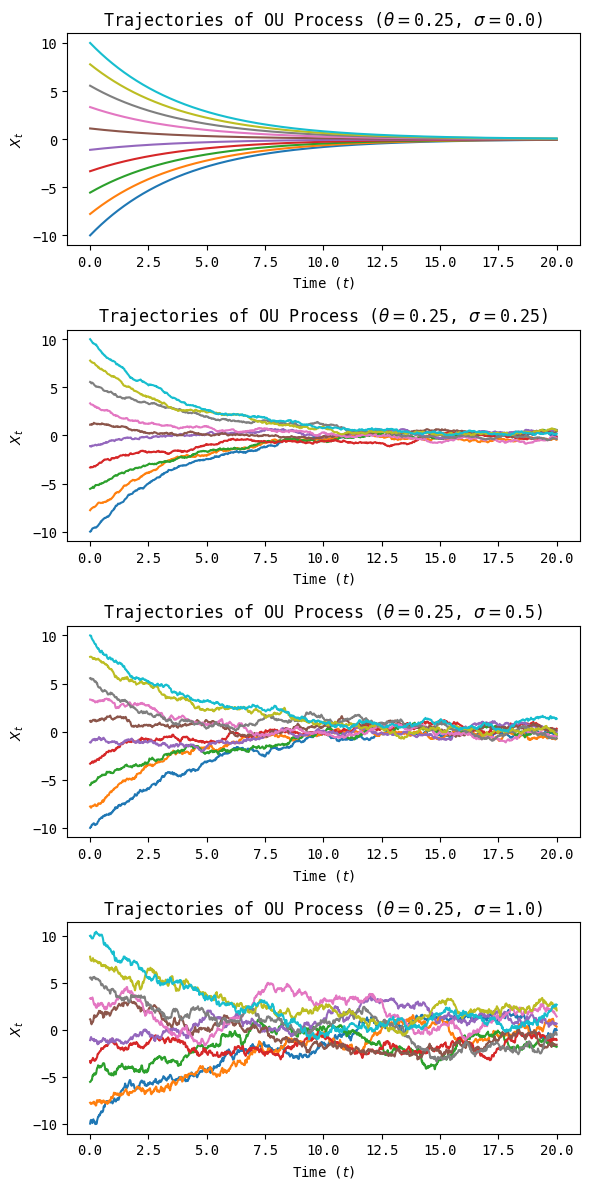

In [12]:
thetas_and_sigmas = [(0.25, 0.0),
                     (0.25, 0.25),
                     (0.25, 0.5),
                     (0.25, 1.0)]

simulation_time = 20.0
num_plots = len(thetas_and_sigmas)

fig, axes = plt.subplots(num_plots, 1, figsize = (6, 3 * num_plots))
for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
    ou_process = OUProcess(theta, sigma)
    simulator = EulerMaruyamaSimulator(sde = ou_process)
    # Create 10 trajectories with theta ranging from [-10, 10], and 1000 time
    # steps with t ranging from [0, 20]
    x0 = torch.linspace(-10.0, 10.0, 10).view(-1, 1).to(device)
    ts = torch.linspace(0.0, simulation_time, 1000).to(device)

    ax = axes[idx]
    ax.set_title(f"Trajectories of OU Process ($\\theta = ${theta}, $\\sigma = ${sigma})")
    ax.set_xlabel(r"Time ($t$)")
    ax.set_ylabel(r"$X_t$")

    plot_trajectories_1d(x0, simulator, ts, ax)
fig.tight_layout()

Let us now set $D \triangleq\frac{\sigma^2}{2\theta}$. The spatial scale is then given by the _fluctuation amplitude_ or standard deviation $\sqrt D$. The time scale is given by the characteristic time for the corresponding ODE:
$$
\begin{align*}
\mathrm dX_t & = -\theta X_t\,\mathrm dt \\
\int\frac{\mathrm dX_t}{X_t} & = -\int\theta\,\mathrm dt \\
\log X_t & = -\theta t + C \\
X_t & = X_0\exp\left[-\theta t\right],
\end{align*}
$$
such that the characteristic time $\frac{1}{\theta}$ is the time it takes for the ODE to decay to $\frac{1}{e}$ of its original value. Then, $\mathrm dX_t' =\frac{\mathrm dX_t}{\sqrt{D}}$, $t' = \frac{t}{1/\theta} = \theta t$, and
$$
\begin{align*}
\mathrm dW_t' = \mathcal N\left(0, \theta\,\mathrm dt\right) & \rightarrow \mathrm dW_t = \frac{\mathrm dW_t'}{\sqrt\theta}\\
\mathrm dX'_t\sqrt{D} & = -\theta X_t'\sqrt{D}\,\frac{\mathrm dt'}{\theta} + \frac{\sigma}{\sqrt\theta}\,\mathrm dW_{t'} \\
\mathrm dX'_t & = -X'_t\,\mathrm dt' + \frac{\sigma}{\sqrt\frac{\sigma^2}{2}}\mathrm dW_{t'} \\
& = -X'_t\,\mathrm dt' + \sqrt{2}\,\mathrm dW_{t'},
\end{align*}
$$
hinting at a universal form for all Ornstein-Uhlenbeck processes.

In [13]:
def plot_scaled_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, time_scale: float, label: str, ax: Optional[Axes] = None):
    """
    Plot multiple 1D SDE trajectories given initial states (x0) and simulation
    time steps (timesteps), scaled by time_scale.

    Parameters
    ----------
    x0 : torch.Tensor, shape (num_trajectories, 1)
        Initial state for each trajectory at time 0.
    simulator : Simulator
        Object used to generate trajectories.
    timesteps : torch.Tensor, shape (num_timesteps, )
        Time points for simulation.
    time_scale : float
        Multiplicative factor by which to scale time
    label : str
        Legend label.
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on. Uses the current axes if None.
    """
    if ax is None:
        ax = plt.gca()
    # Simulate trajectories: shape (num_trajectories, num_timesteps, 1)
    trajectories = simulator.simulate_with_trajectory(x0, timesteps)
    for trajectory_idx in range(trajectories.shape[0]):
        # Extract a single trajectory: shape (num_timesteps, )
        trajectory = trajectories[trajectory_idx, :, 0]
        # Plot trajectories with scaled time, moving tensors to the CPU if nece-
        # ssary.
        ax.plot(timesteps.cpu() * time_scale, trajectory.cpu(), label = label)

100%|██████████| 999/999 [00:00<00:00, 3368.91it/s]


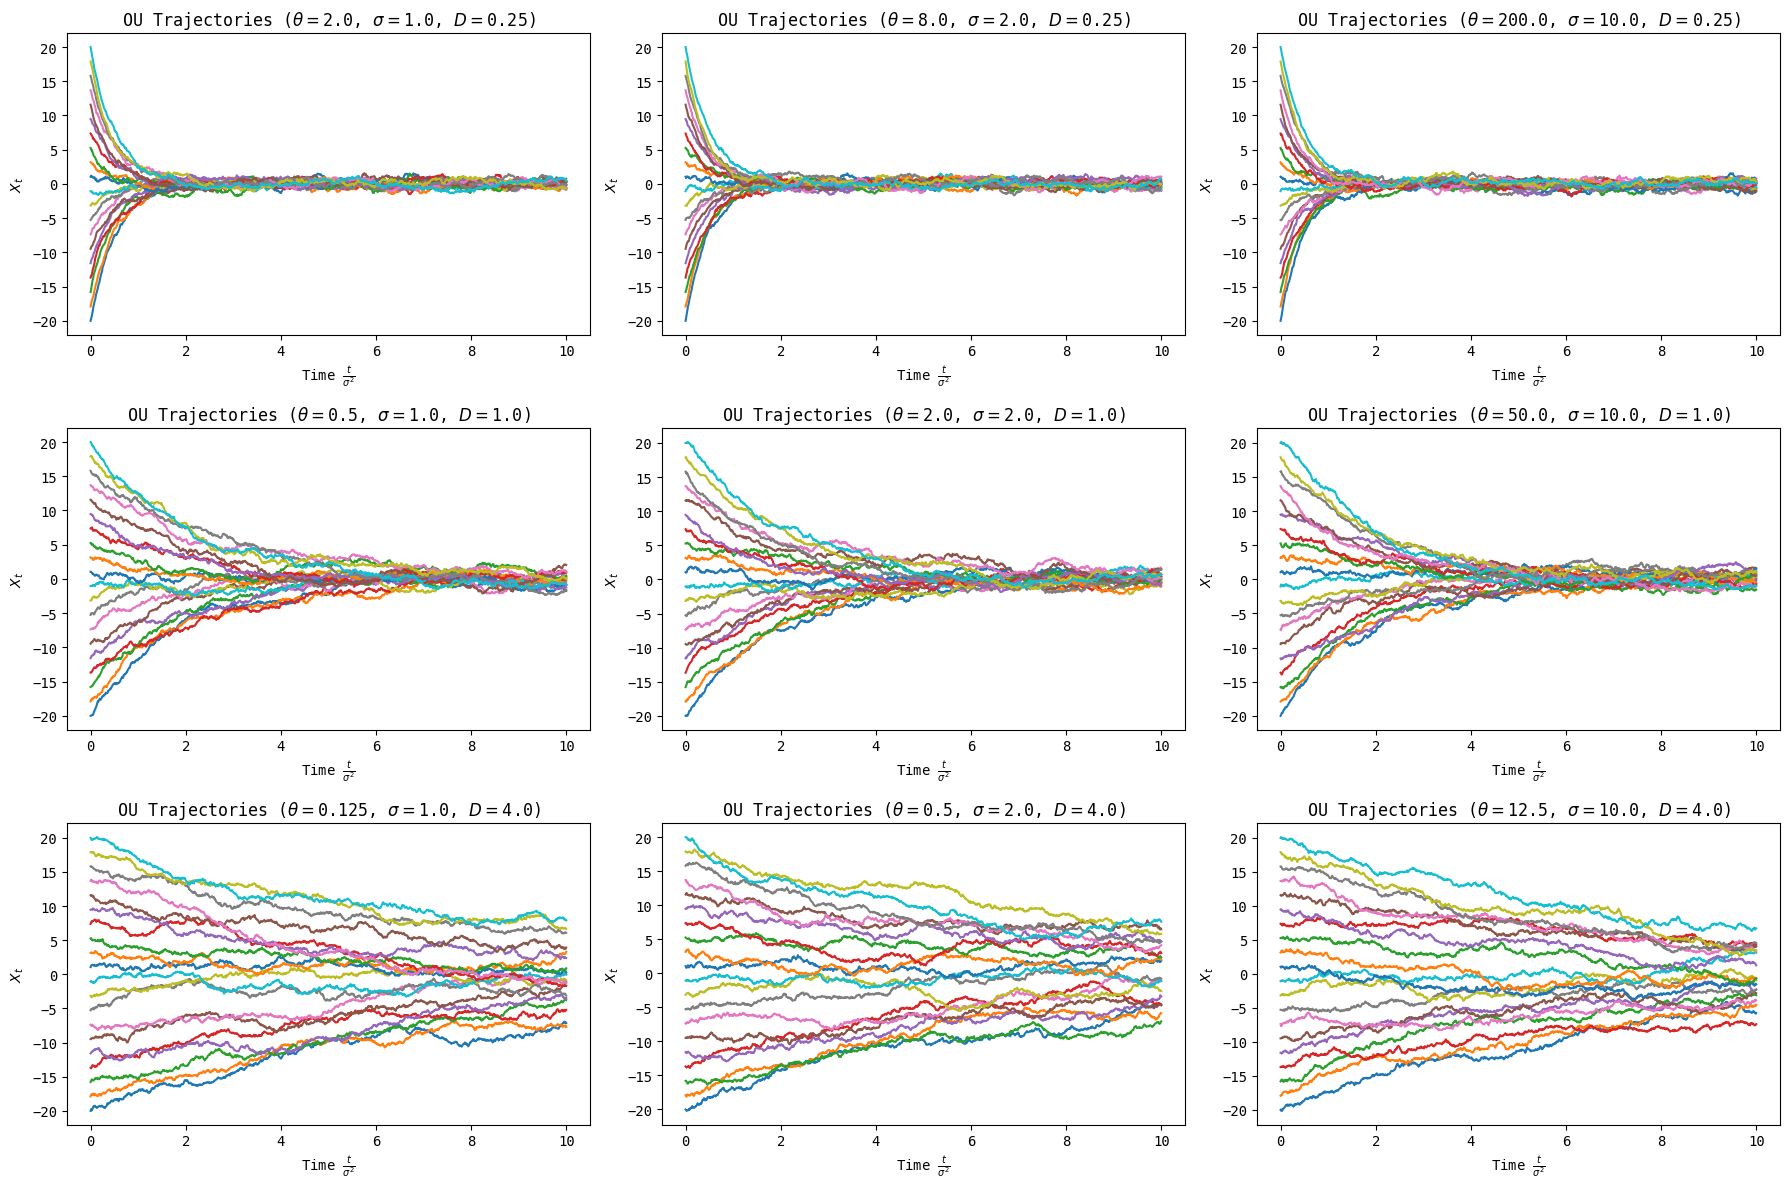

In [14]:
sigmas = [1.0, 2.0, 10.0]
# D = sigma^2 / (2 * theta)
ds = [0.25, 1.0, 4.0]
simulation_time = 10.0

fig, axes = plt.subplots(len(ds), len(sigmas), figsize = (6 * len(sigmas), 4 * len(ds)))
for d_idx, d in enumerate(ds):
    for s_idx, sigma in enumerate(sigmas):
        theta = sigma ** 2 / (2 * d)
        ou_process = OUProcess(theta, sigma)
        simulator = EulerMaruyamaSimulator(sde = ou_process)

        x0 = torch.linspace(-20.0, 20.0, 20).view(-1, 1).to(device)
        # Time scaled by sigma^2 measures time in Wiener variance units
        time_scale = sigma ** 2
        ts = torch.linspace(0.0, simulation_time / time_scale, 1000).to(device)

        ax = axes[d_idx, s_idx]
        # Fixed D yields identical trajectories in rescaled time
        plot_scaled_trajectories_1d(x0 = x0, simulator = simulator, timesteps = ts, time_scale = time_scale, label = f"Sigma = {sigma}", ax = ax)
        ax.set_title(f"OU Trajectories ($\\theta = ${theta}, $\\sigma = ${sigma}, $D = ${d})")
        ax.set_xlabel(r"Time $\frac{t}{\sigma^2}$")
        ax.set_ylabel(r"$X_t$")
fig.tight_layout()

## Transforming Distributions

We now turn to the problem of transforming _distributions_, rather than just individual points, using SDEs. Our goal is to transform an initial noisy distribution $p_\mathrm{init}$, such as a standard Gaussian $\mathcal N(0, I_d)$, into a target data distribution $p_\mathrm{data}$ of interest. We will do so using _Langevin dynamics_. Our distribution should have the following desired properties:

1. The distribution must have a measurable _density_, such that its _score function_ $\nabla\log p_t(x)$ can be evaluated. The score defines a velocity field pointing in the direction of greatest probability increase, driving the distribution from $p_\mathrm{init}$ towards $p_\mathrm{data}$.

2. Given the score, we can construct an overdamped Langevin dynamics $-$ i.e., the high-friction limit $\left(\gamma = \frac{2}{\sigma_t^2}\rightarrow\infty\right)$ of the corresponding underdamped dynamics, in which inertia becomes negligible $-$ such that the state evolves according to
$$
\mathrm dX_t = \frac{\sigma^2_t}{2}\nabla\log p(X_t)\,\mathrm dt + \sigma_t\,\mathrm dW_t,
$$
in which the distribution $p_t(x) = p$ is _stationary_, i.e.,
$$
\begin{align*}
\partial_t p_t & = -\nabla\cdot\left[\left(\frac{\sigma^2_t}{2}\nabla\log p_t(x) - \frac{\sigma_t^2}{2}\nabla\right)p_t(x)\right] \\
& = -\nabla\cdot\left[\frac{\sigma_t^2}{2}\Big[p_t(x)\nabla\log p_t(x) - \nabla p_t(x)\Big]\right] \\
& = 0,
\end{align*}
$$
corresponding to the target (data) distribution $p_\mathrm{data}$ (often denoted by $\pi$).

3. We need to be able to draw samples from the distribution. For simple toy distributions, such as Gaussians or mixture models, both sampling and density evaluation are possible. For more complex distributions, such as those over images, the density may not be measurable, although sampling remains possible.

In [15]:
class Density(ABC):
    """
    Probability distribution with tractable (measurable) density.
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log probability density for a batch of samples.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, dim)
            Batch of input samples.

        Returns
        -------
        log_density : torch.Tensor, shape (batch_size, 1)
            Log density [log p(x)] for each input sample.
        """
        pass

    def score(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the score function [nabla_x log p(x)] for a batch of samples.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, dim)
            Batch of input samples.

        Returns
        -------
        score : torch.Tensor, shape (batch_size, dim)
            Gradient of the log density with respect to x for each input sample,
            representing the score [nabla_x log p(x)].
        """
        # Add dimension of size one for compatibility with log_density, resul-
        # ting in shape (batch_size, 1, dim).
        x = x.unsqueeze(1)
        # log_density maps an input of shape (1, dim) to shape (1, 1). jacrev
        # computes the Jacobian of log_density with respect to x, producing
        # shape (1, 1, 1, dim) for a single sample. vmap applies this computa-
        # tion over the batch dimension, yielding aggregated results with shape
        # (batch_size, 1, 1, 1, dim).
        score = vmap(jacrev(self.log_density))(x)
        # Return score vector for each sample by removing dimensions of size
        # one: (batch_size, dim)
        return score.squeeze((1, 2, 3))

In [16]:
class Sampleable(ABC):
    """
    Distribution that can be sampled from.
    """
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Generate samples from the distribution.

        Parameters
        ----------
        num_samples : int
            Number of samples to generate (i.e., batch size).

        Returns
        -------
        samples : torch.Tensor, shape (num_samples, dim)
            Samples from the distribution.
        """
        pass

In [17]:
# Visualize 2D samples from a Sampleable distribution as histograms and scatter
# plots
def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (num_samples, 2)
    ax.hist2d(samples[:, 0].cpu(), samples[:, 1].cpu(), **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (num_samples, 2)
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), **kwargs)

In [18]:
# Evaluate the log probability density on a 2D meshgrid and plot as a heatmap or
# contour
def imshow_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y, indexing = "ij")
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim = -1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent = [-scale, scale, -scale, scale], origin = "lower", **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y, indexing = "ij")
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim = -1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), extent = [-scale, scale, -scale, scale], origin = "lower", **kwargs)

In [19]:
class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian distribution that can both be measured (Density)
    and sampled from (Sampleable). Acts as a wrapper around PyTorch's Multi-
    variateNormal distribution.
    """
    def __init__(self, mean, cov):
        """
        Initialize a 2-dimensional Gaussian distribution.

        Parameters
        ----------
        mean : torch.Tensor, shape (2, )
            Mean vector of the distribution.
        cov : torch.Tensor, shape (2, 2)
            Covariance matrix of the distribution.
        """
        # The constructor of the first base class (Module) is called.
        super().__init__()
        # Register the mean and covariance as buffers so that they are tracked
        # as part of the module state but not treated as learnable parameters.
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def distribution(self):
        """
        Returns a 2D Gaussian with the stored mean and covariance. Skip argument
        validation, and expose as a read-only property (attribute).

        Returns
        -------
        torch.distributions.MultivariateNormal
            Multivariate Gaussian parameterized by the stored mean and covari-
            ance.
        """
        return D.MultivariateNormal(self.mean, self.cov, validate_args = False)

    def sample(self, num_samples) -> torch.Tensor:
        """
        Draw random samples from the Gaussian distribution.

        Parameters
        ----------
        num_samples : int
            Number of samples to draw from the distribution.

        Returns
        -------
        torch.Tensor, shape (num_samples, 2)
            Samples drawn from the distribution.
        """
        return self.distribution.sample((num_samples, ))

    def log_density(self, x: torch.Tensor):
        """
        Compute the log probability density for the given input values.

        Parameters
        ----------
        x : torch.Tensor, shape (num_samples, 2)
            Points at which to evaluate the log probability density.

        Returns
        -------
        torch.Tensor, shape (num_samples, 1)
            Log probability densities evaluated at the given points, reshaped
            into a column vector.
        """
        return self.distribution.log_prob(x).view(-1, 1)

In [20]:
class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model that supports both density evaluation
    (Density) and sampling (Sampleable). Wraps PyTorch's MixtureSameFamily dis-
    tribution to create a mixture of Gaussian distributions, each with its own
    mean, covariance, and weight.
    """
    def __init__(self, means: torch.Tensor, covs: torch.Tensor, weights: torch.Tensor):
        """
        Initialize a Gaussian mixture model.

        Parameters
        ----------
        means : torch.Tensor, shape (nmodes, 2)
            Mean vector for each Gaussian component in the mixture. Each row re-
            presents a component's 2D mean.
        covs : torch.Tensor, shape (nmodes, 2, 2)
            Covariance matrix for each Gaussian component in the mixture. Each
            entry represents the covariance matrix of one component.
        weights : torch.Tensor, shape (nmodes, 1)
            Weights (probabilities) of selecting each component in the mixture.
            These must sum to 1, and each weight must be non-negative.
        """
        # Initialize the parent Module class
        super().__init__()
        # The number of modes is inferred from the shape of the means tensor
        self.nmodes = means.shape[0]
        # Register the means, covariances, and weights as buffers so that they
        # are tracked as part of the module state.
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        """
        Return the dimension of the mixture model, i.e., the second dimension of
        the mean tensor.
        """
        return self.means.shape[1]

    @property
    def distribution(self):
        """
        Construct and return the mixture distribution. Use the stored weights to
        specify the probability of each component. Each component is a multivari-
        ate Gaussian parameterized by its corresponding mean and covariance ma-
        trix.

        Returns
        -------
        torch.distributions.mixture_same_family.MixtureSameFamily
            Gaussian mixture model parameterized by the stored means, covariance
            matrices, and component weights.
        """
        return D.MixtureSameFamily(mixture_distribution = D.Categorical(probs = self.weights,
                                                                        validate_args = False),
                                   component_distribution = D.MultivariateNormal(loc = self.means,
                                                                                 covariance_matrix = self.covs,
                                                                                 validate_args = False),
                                   validate_args = False)

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute and return the log density of the distribution, at the given po-
        sition, as a column vector.
        """
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Sample from the 2D Gaussian mixture model and return a tensor of shape
        (num_samples, 2).
        """
        return self.distribution.sample(torch.Size((num_samples, )))

    @classmethod
    def random_2D(cls, nmodes: int, std: float, scale: float = 10.0, seed = 0.0) -> "GaussianMixture":
        """
        Initialize a 2D Gaussian mixture model with the specified number of com-
        ponents, standard deviation, and mean scaling factor.

        Parameters
        ----------
        nmodes : int
            Number of Gaussian components (modes) in the mixture model
        std : float
            Standard deviation of each Gaussian component. Sets the diagonal
            entries (variance) of each component's covariance matrix.
        scale : float, optional
            Scaling factor for component means. Component means are randomly
            sampled from U(-0.5, 0.5) * scale. Default is 10.0.
        seed : float, optional
            Seed for the random number generator to ensure reproducibility of
            results. Default is 0.0.

        Returns
        -------
        GaussianMixture
            Gaussian mixture model with the given number of components, standard
            deviation, and mean scaling factor.
        """
        # Set the random seed to ensure reproducibility
        torch.manual_seed(seed)
        # Initialize the means for the Gaussian components. The means are ran-
        # domly sampled from U(-0.5, 0.5) * scale.
        means = (torch.rand(nmodes, 2) - 0.5) * scale
        # Construct a covariance matrix of shape (nmodes, 2, 2), denoting the
        # variance along each axis for each component.
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        # Assign equal weights to each component by passing a vector of ones.
        # Each component will have the same probability of being selected in
        # the mixture.
        weights = torch.ones(nmodes)
        # Return the constructed Gaussian mixture model with the given means,
        # covariances, and weights
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(cls, nmodes: int, std: float, scale: float = 10.0) -> "GaussianMixture":
        """
        Initialize a 2D Gaussian mixture model with component means evenly spaced
        around the unit circle.

        Parameters
        ----------
        nmodes : int
            Number of Gaussian components (modes) in the mixture model
        std : float
            Standard deviation of each Gaussian component. Sets the diagonal en-
            tries (variances) of each component's covariance matrix.
        scale : float, optional
            Scaling factor for component means. The means are distributed around
            the unit circle and then scaled by this factor. Default is 10.0.

        Returns
        -------
        GaussianMixture
            Gaussian mixture model with the specified number of components, stan-
            dard deviation, and mean scaling factor.
        """
        # Partition the range [0, 2 * pi) into "nmodes" evenly spaced angles,
        # excluding 2 * pi since it is equivalent to 0.
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        # Construct mean vectors as (cos, sin) of the angles, evenly distribu-
        # ting points around the unit circle, then scale them by the given fac-
        # tor.
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim = 1) * scale
        # Construct a covariance matrix with equal variance along each axis for
        # each component.
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        # Assign equal weights to each component (1 / nmodes).
        weights = torch.ones(nmodes) / nmodes
        # Return the Gaussian mixture model with the specified means, covarian-
        # ces, and weights.
        return cls(means, covs, weights)

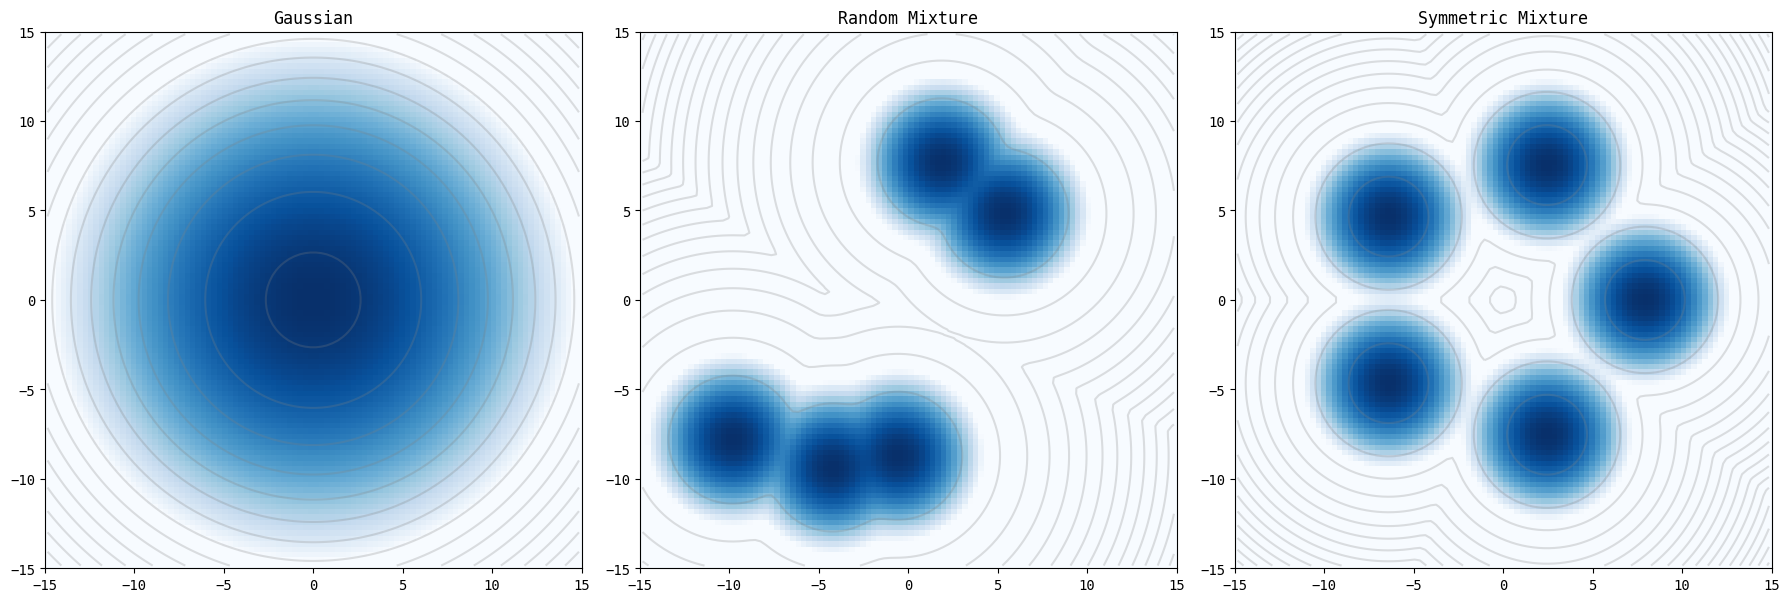

In [21]:
# Initialize a 2D Gaussian with mean 0 and covariance 10 * I; a mixture of 5
# Gaussians, where each component is distributed as N(mu, 1) and mu ~ U(-10,
# 10); and a second mixture of 5 Gaussians with unit variance, where component
# means are spaced evenly on a circle of radius 8 at intervals of 2 * pi / 5.
densities = {"Gaussian": Gaussian(mean = torch.zeros(2), cov = 10 * torch.eye(2)).to(device),
             "Random Mixture": GaussianMixture.random_2D(nmodes = 5, std = 1.0, scale = 20.0, seed = 3.0).to(device),
             "Symmetric Mixture": GaussianMixture.symmetric_2D(nmodes = 5, std = 1.0, scale = 8.0).to(device)}

fig, axes = plt.subplots(1, 3, figsize = (18, 6))
bins = 100
scale = 15
for idx, (name, density) in enumerate(densities.items()):
    ax = axes[idx]
    ax.set_title(name)
    imshow_density(density, bins, scale, ax, vmin = -15, cmap = plt.get_cmap("Blues"))
    contour_density(density, bins, scale, ax, colors = "grey", linestyles = "solid", alpha = 0.25, levels = 20)
fig.tight_layout()

Let us now implement the Langevin dynamics.

In [22]:
class LangevinSDE(SDE):
    def __init__(self, sigma: float, density: Density):
        self.sigma = sigma
        self.density = density

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient for overdamped Langevin dynamics.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        drift : torch.Tensor, shape (batch_size, dim)
            Drift coefficient for overdamped Langevin dynamics.
        """
        drift = self.density.score(xt) * self.sigma ** 2 / 2
        return drift

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient for overdamped Langevin dynamics.

        Parameters
        ----------
        xt : torch.Tensor, shape (batch_size, dim)
            Current state at time t.
        t : torch.Tensor, shape ()
            Current time (broadcasts across batch).

        Returns
        -------
        diffusion : torch.Tensor, shape (batch_size, dim)
            Diffusion coefficient for overdamped Langevin dynamics.
        """
        diffusion = torch.ones_like(xt) * self.sigma
        return diffusion

In [23]:
def every_nth_index(num_timesteps: int, n: int) -> torch.Tensor:
    """
    Compute indices to record in a trajectory. If the step size is greater than
    1, return every n-th index up to the last index, and append the final time
    step (num_timesteps - 1) to ensure it is included.
    """
    if n == 1:
        return torch.arange(num_timesteps)
    return torch.cat([torch.arange(0, num_timesteps - 1, n),
                      torch.tensor([num_timesteps - 1])])

In [24]:
def graph_dynamics(num_samples: int,
                   source_distribution: Sampleable,
                   simulator: Simulator,
                   density: Density,
                   timesteps: torch.Tensor,
                   plot_every: int,
                   bins: int,
                   scale: float):
    """
    Plot the time evolution of samples from a Sampleable source distribution un-
    der the given simulation scheme.

    Parameters
    ----------
    num_samples : int
        Number of samples to simulate
    source_distribution : Sampleable
        Distribution from which to sample initial states at t = 0.
    simulator : Simulator
        Discretized simulation scheme used to simulate the dynamics.
    density : Density
        Target density for visualization.
    timesteps : torch.Tensor, shape (num_timesteps, )
        Time steps along which to simulate the trajectories.
    plot_every : int
        Step size used in plotting the trajectory.
    bins : int
        Resolution of the plotted grid.
    scale : float
        Extent of the plotted grid, i.e., from [-scale, scale] on both axes.
    """
    # Sample num_samples samples from the source distribution to form the initial
    # state x_0
    x0 = source_distribution.sample(num_samples)
    # Simulate for the given set of time steps and record the full trajectory
    xts = simulator.simulate_with_trajectory(x0, timesteps)
    # Retrieve the set of time steps to plot
    indices_to_plot = every_nth_index(len(timesteps), plot_every)
    plot_timesteps = timesteps[indices_to_plot]
    # Select every plot_every-th time step for plotting
    plot_xts = xts[:, indices_to_plot]

    fig, axes = plt.subplots(2, len(plot_timesteps), figsize = (8 * len(plot_timesteps), 16),
                             constrained_layout = True, sharex = True, sharey = True)
    axes = axes.reshape((2, len(plot_timesteps)))
    for t_idx in range(len(plot_timesteps)):
        t = plot_timesteps[t_idx].item()
        xt = plot_xts[:, t_idx]
        scatter_ax = axes[0, t_idx]
        imshow_density(density, bins, scale, scatter_ax, vmin = -15, alpha = 0.25, cmap = plt.get_cmap("Blues"))
        scatter_ax.scatter(xt[:, 0].cpu(), xt[:, 1].cpu(), marker = "x", color = "black", alpha = 0.75, s = 15)
        scatter_ax.set_title(f"Samples at t = {t:.1f}", fontsize = 25)
        scatter_ax.set_xticks([])
        scatter_ax.set_yticks([])

        kdeplot_ax = axes[1, t_idx]
        imshow_density(density, bins, scale, kdeplot_ax, vmin = -15, alpha = 0.5, cmap = plt.get_cmap("Blues"))
        sns.kdeplot(x = xt[:, 0].cpu(), y = xt[:, 1].cpu(), alpha = 0.5, ax = kdeplot_ax, color = "grey")
        kdeplot_ax.set_title(f"Density of Samples at t = {t:.1f}", fontsize = 25)
        kdeplot_ax.set_xticks([])
        kdeplot_ax.set_yticks([])
        kdeplot_ax.set_xlabel("")
        kdeplot_ax.set_ylabel("")

100%|██████████| 999/999 [00:03<00:00, 296.45it/s]


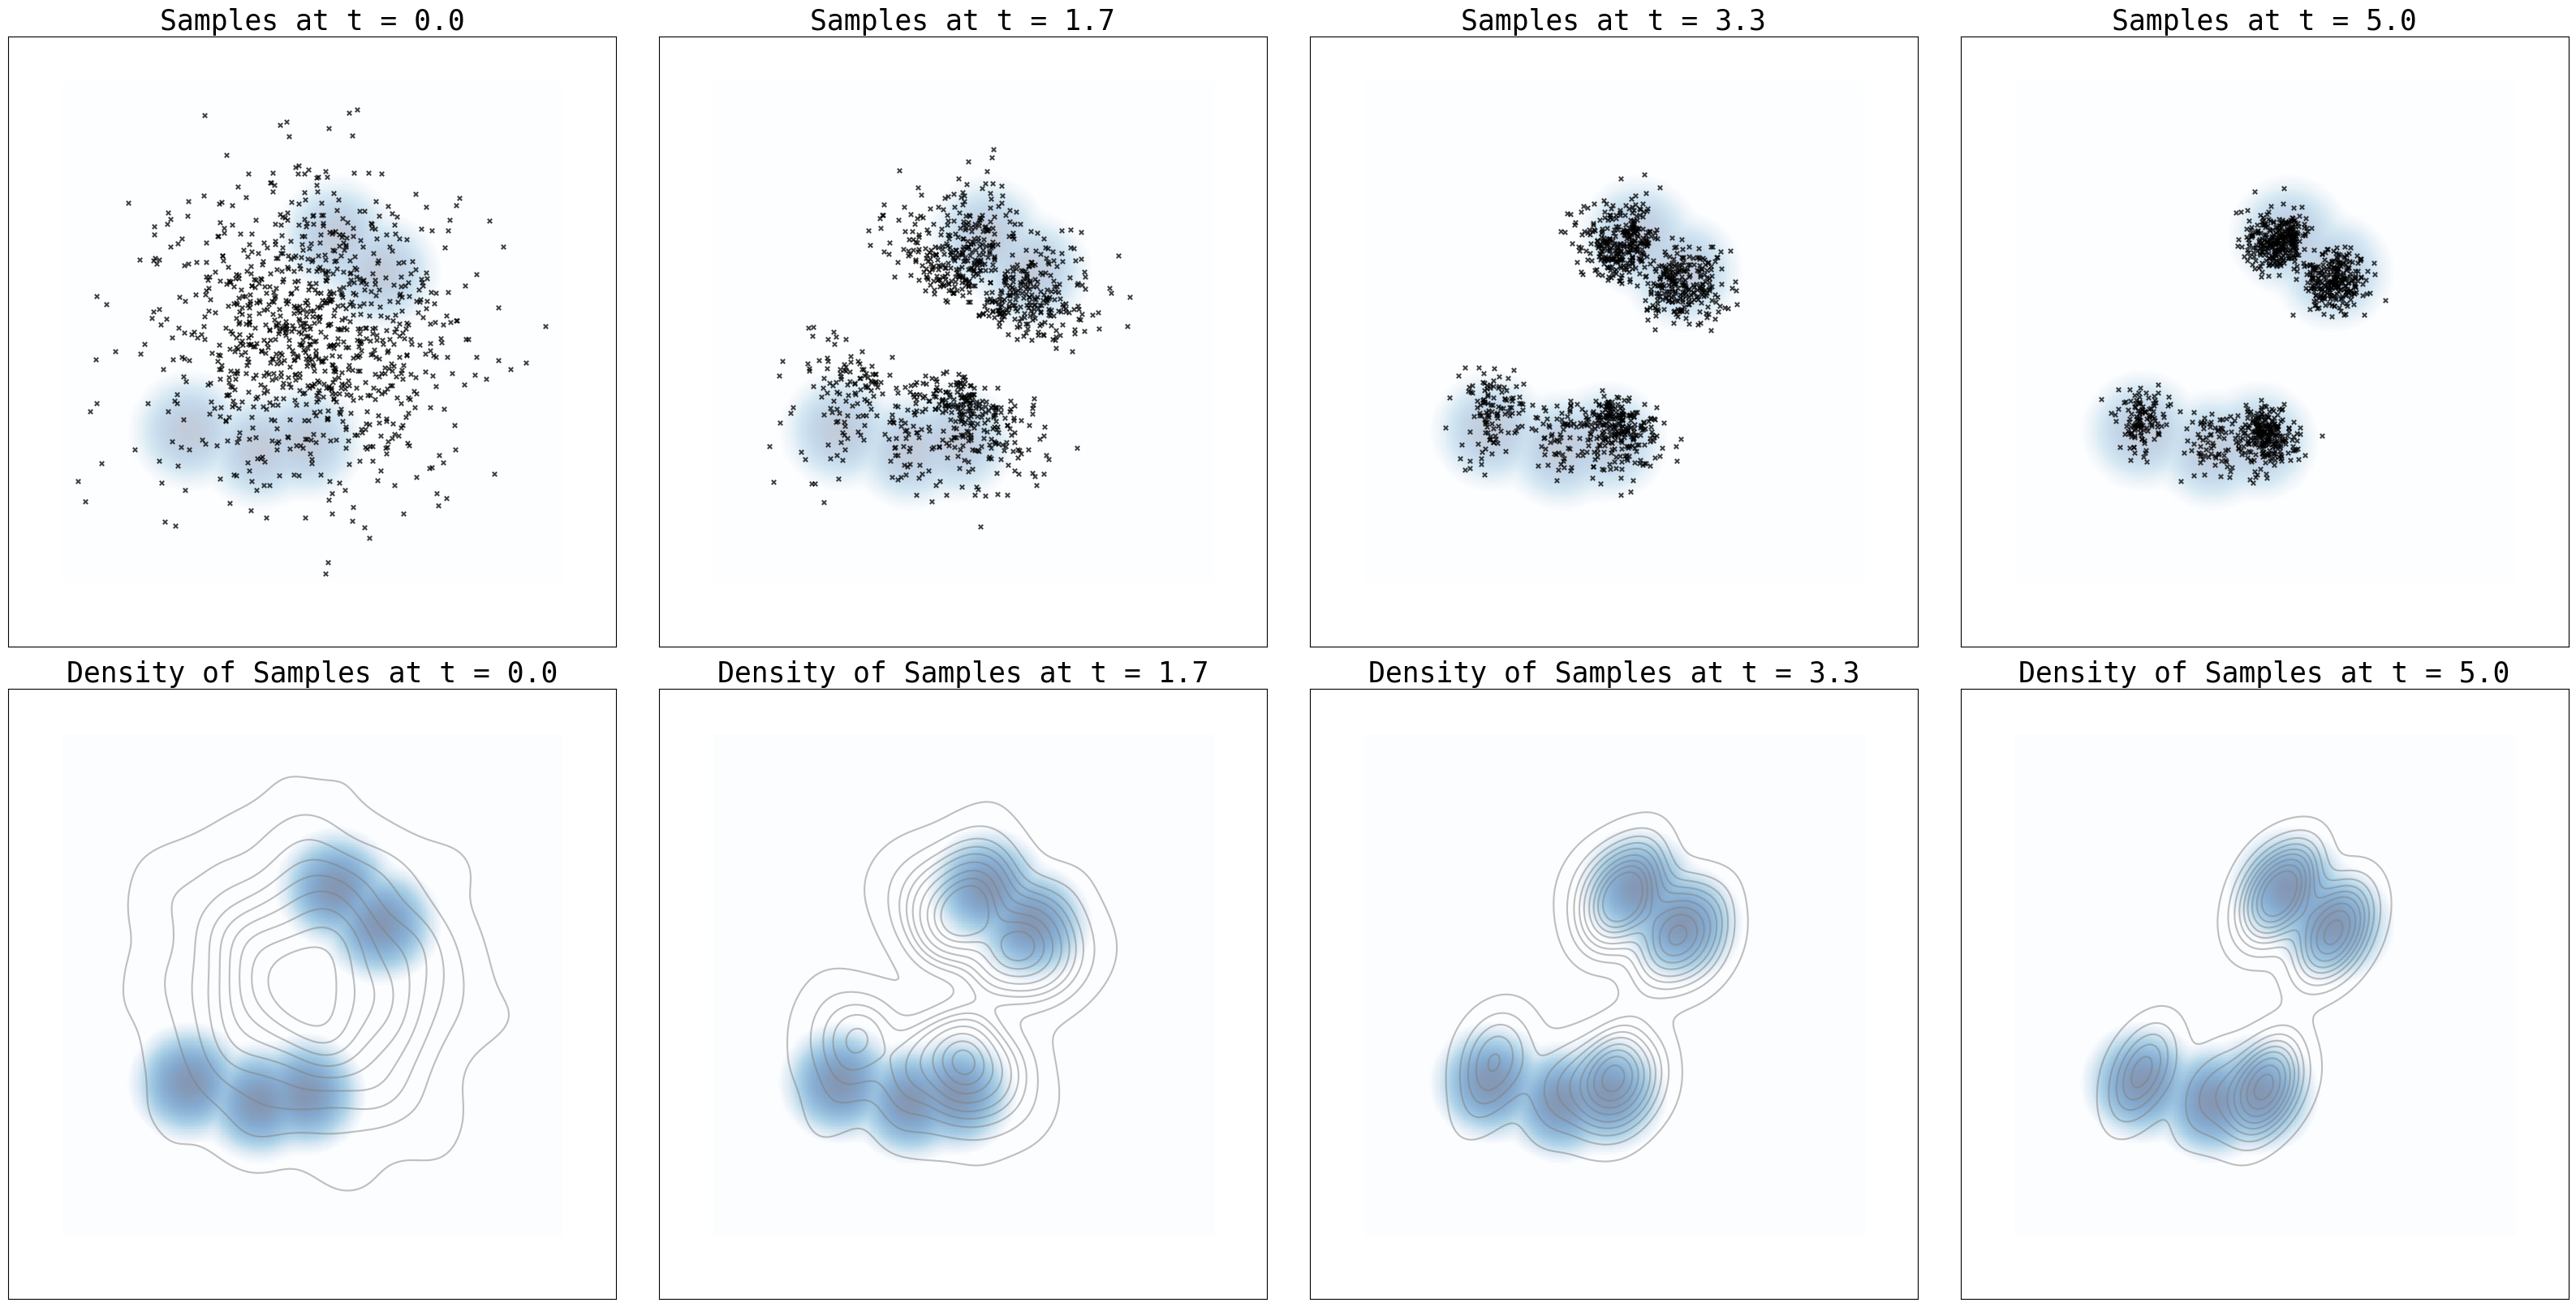

In [25]:
# Create a Gaussian mixture model with 5 components, each with a standard devi-
# ation of 0.75 and mean sampled from U(-7.5, 7.5).
target = GaussianMixture.random_2D(nmodes = 5, std = 0.75, scale = 15.0, seed = 3.0).to(device)
# Initialize a Langevin SDE with the mixture model as the target density and a
# diffusion coefficient (controlling the noise magnitude) of 0.6
sde = LangevinSDE(sigma = 0.6, density = target)
# Instantiate the Euler-Maruyama simulator
simulator = EulerMaruyamaSimulator(sde)

# Sample 1000 points from N(0, 20 * I), and visualize its evolution towards the
# target distribution
graph_dynamics(num_samples = 1000,
               source_distribution = Gaussian(mean = torch.zeros(2), cov = 20 * torch.eye(2)).to(device),
               simulator = simulator,
               density = target,
               timesteps = torch.linspace(0, 5.0, 1000).to(device),
               plot_every = 334,
               bins = 200,
               scale = 15)

A larger $\sigma$ increases the noise magnitude, allowing for more efficient exploration of the state space and faster convergence onto a multi-modal target distribution (such as a Gaussian mixture) by facilitating escapes from local minima. Increasing the trajectory length provides more time for the dynamics to converge onto the target distribution.

Let us now connect Langevin dynamics to the Ornstein-Uhlenbeck process. We previously showed that the stationary distribution corresponding to
$$
\mathrm dX_t = -\theta X_t\,\mathrm dt + \sigma\,\mathrm dW_t, \, X_0 = x_0
$$
follows $\mathcal N\left(0, \frac{\sigma^2}{2\theta}\right)$, or
$$
p(x) = \sqrt\frac{\theta}{\pi\sigma^2}\exp\left[-\frac{\theta x^2}{\sigma^2}\right].
$$
For the Langevin dynamics
$$
\mathrm dX_t = \frac{\sigma^2}{2}\nabla\log p(X_t)\,\mathrm dt + \sigma\,\mathrm dW_t,
$$
the score follows
$$
\begin{align*}
\nabla\log p(x) & = \nabla\left[\log\sqrt\frac{\theta}{\pi\sigma^2} - \frac{\theta x^2}{\sigma^2}\right] \\
& = -\frac{2\theta x}{\sigma^2},
\end{align*}
$$
and so
$$
\begin{align*}
\mathrm dX_t & = \frac{\sigma^2}{2}\left(-\frac{2\theta X_t}{\sigma^2}\right)\,\mathrm dt + \sigma\,\mathrm dW_t \\
& = -\theta X_t\,\mathrm dt + \sigma\,\mathrm dW_t,
\end{align*}
$$
recovering the Ornstein-Uhlenbeck process.